# Python idioms performance characteristics

I've been meaning to check this out for a long time.

The setup is simple. We write a monstrous decorator which modifies a simple function that iterates n times, to a function that runs the former on a number of inputs and returns how long each run took.

I'm not in the business of 4% performance improvements here. I'm after quadratic behavior!

In [2]:
from time import time
import numpy as np
import matplotlib.pyplot as plt
from collections import deque
import random
%matplotlib inline

In [3]:
def benchmark(counts):
    def times(f):
        def ret():
            timings = []
            for c in counts:
                start = time()
                f(c)
                timings.append(time() - start)
            return timings
        return ret
    return times

Let's start with the obvious: repeated string concatenation. Everyone knows about that one, right? 

In [3]:
counts = [int(x) for x in np.logspace(4, 7, num=40)]

@benchmark(counts)
def accumulate_strings(n):
    s = ''
    for i in range(n):
        s += 'a'

@benchmark(counts)
def list_join(n):
    l = []
    for i in range(n):
        l.append('a')
    ''.join(l)

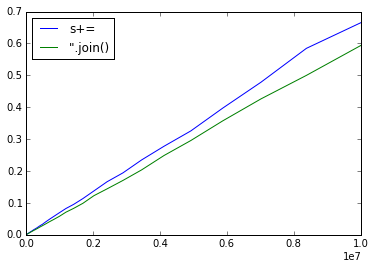

In [4]:
plt.plot(counts, accumulate_strings())
plt.plot(counts, list_join())
plt.legend(['s+=', "''.join()"], loc='best')

Looks pretty linear to me. Apparently string `+=` runs in `O(1)`. That was honestly a shocking discovery to me. I've been telling people to avoid string `+=` for years!

Let's test another common truth - that you should use a deque for repeated `append` and `pop` operations.

In [5]:
counts = [int(x) for x in np.logspace(4, 6)]

@benchmark(counts)
def add_remove_deque(n):
    q = deque()
    for i in range(n):
        q.append(i)
    for i in range(n):
        q.pop()
        
@benchmark(counts)
def add_remove_list(n):
    l = []
    for i in range(n):
        l.append(i)
    for i in range(n):
        l.pop()

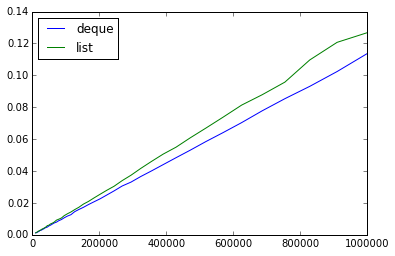

In [6]:
plt.plot(counts, add_remove_deque())
plt.plot(counts, add_remove_list())
plt.legend(['deque', 'list'], loc='best')

Seems like they're both linear time. Hey, how much is that is overhead?

In [7]:
@benchmark(counts)
def just_pass(n):
    l = []
    for i in range(n):
        pass
    for i in range(n):
        pass
    
plt.plot(counts, add_remove_deque())
plt.plot(counts, add_remove_list())
plt.plot(counts, just_pass())
plt.legend(['deque', 'list', 'pass'], loc='best')

Not that much. What if we insert to the end and take from the beginning?

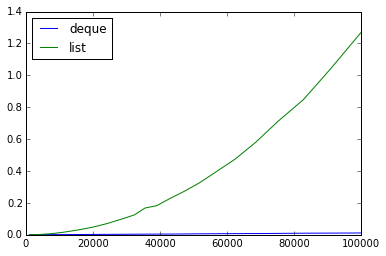

In [8]:
counts = [int(x) for x in np.logspace(3, 5)]

@benchmark(counts)
def append_pop0_deque(n):
    q = deque()
    for i in range(n):
        q.append(i)
    for i in range(n):
        q.popleft()
        
@benchmark(counts)
def append_pop0_list(n):
    l = []
    for i in range(n):
        l.append(i)
    for i in range(n):
        l.pop(0)
        
plt.plot(counts, append_pop0_deque())
plt.plot(counts, append_pop0_list())
plt.legend(['deque', 'list'], loc='best')

Finally we see a quadratic function. Seems that lists are fine with adding and removing from one end, but they're really bad when you need to `pop(0)` repeatedly.

Are strings the same?

In [9]:
counts = [int(x) for x in np.logspace(3, 5)]

@benchmark(counts)
def accumulate_right(n):
    s = ''
    for i in range(n):
        s = s + 'a'

@benchmark(counts)
def accumulate_left(n):
    s = ''
    for i in range(n):
        s = 'a' + s
        
plt.plot(counts, accumulate_right())
plt.plot(counts, accumulate_left())
plt.legend(["s = s + 'a'", "s = 'a' + s"], loc='upper left')

Certainly seems so. That one is a little strange. If `x` and `y` are strings, `x + y` runs in `O(len(y))`.

Out of curiosity, let's check the `bytes` type.

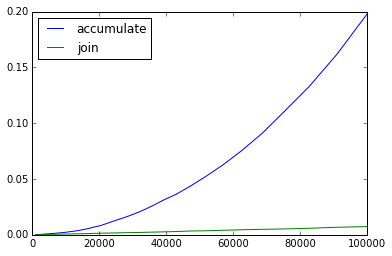

In [10]:
counts = [int(x) for x in np.logspace(3, 5)]

@benchmark(counts)
def accumulate_bytes(n):
    s = b''
    for i in range(n):
        s += b'a'
        
@benchmark(counts)
def join_bytes(n):
    l = []
    for i in range(n):
        l.append(b'a')
    b''.join(l)

plt.plot(counts, accumulate_bytes())
plt.plot(counts, join_bytes())
plt.legend(['accumulate', 'join'], loc='upper left')

In [7]:
counts = [int(x) for x in np.logspace(3, 6)]

@benchmark(counts)
def accumulate_1ref(n):
    s = ''
    for i in range(n):
        s += 'a'
        
@benchmark(counts)
def accumulate_2ref(n):
    s = ''
    blah = s
    q = s
    for i in range(n):
        s += 'a'

plt.plot(counts, accumulate_1ref())
plt.plot(counts, accumulate_2ref())
plt.legend(['1ref', '2ref'], loc='best')

###Let's recap:

 * There's actually nothing wrong with a `+=` loop for strings. We may have to re-educate ourselves!
 * `''.join()` is still preferable when you need to accumulate bytes.
 * If you find yourself write `.pop(0)` or `.insert(0)` in a loop, you really want a `collections.deque`.
 * Postulate reaffirmed: Common truths should be tested!
 
 
 -- Noam Mor, 2015